# Goals

This notebook will map pout the burr pipelines that we will use to do document ingestion

## ENV Variables

In [ ]:
# set your OpenAI API key
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

# Load Document

## Search in database

In [4]:
from ragnostic import db
db_path = '+ragnostic_db.db'
db_url = db.create_sqlite_url(db_path)
db_client = db.DatabaseClient(db_url)

documents = db_client.get_documents()
for document in documents:
    doc_id = document.id
    print(f"- filepath: {document.raw_file_path}")
    metadata = db_client.get_metadata(doc_id=doc_id)
    print(f"- metadata:")
    print(metadata.model_dump_json(indent=4))

- filepath: +storage/DOC_053a4p0iar4f.pdf
- metadata:
{
    "doc_id": "DOC_053a4p0iar4f",
    "title": "New Title",
    "authors": null,
    "creation_date": "2025-02-03T11:38:44.895601",
    "page_count": 4,
    "language": null
}
- filepath: +storage/DOC_fib1eu04hzte.pdf
- metadata:
{
    "doc_id": "DOC_fib1eu04hzte",
    "title": "Aeration Costs in Stirred-Tank and Bubble Column Bioreactors",
    "authors": [
        "D. Humbird",
        "R. Davis",
        "J.D. McMillan"
    ],
    "creation_date": "2025-02-03T11:38:45.855115",
    "page_count": 6,
    "language": null
}


## Load Document

In [6]:
# Load document by ID
doc_id = "DOC_fib1eu04hzte"  # Replace with your doc_id
document = db_client.get_document_by_id(doc_id)

# Get metadata if needed
metadata = db_client.get_metadata(doc_id)

print(f"Document: {document.id}")
print(f"File path: {document.raw_file_path}")
print(f"Metadata title: {metadata.title if metadata else 'No metadata'}")

Document: DOC_fib1eu04hzte
File path: +storage/DOC_fib1eu04hzte.pdf
Metadata title: Aeration Costs in Stirred-Tank and Bubble Column Bioreactors


# Extract Content

In [7]:
from pathlib import Path
import docling
from ragnostic.extraction.core.schema import ExtractedImage, ExtractedText, ContentLocation

# Load document with docling
doc_path = Path(document.raw_file_path)
doc = docling.load_document(str(doc_path))

# Process pages
extracted_content = []
for page_num, page in enumerate(doc.pages, start=1):
    # Extract text blocks
    for text_block in page.text_blocks:
        text = ExtractedText(
            content_id=f"txt_{page_num}_{len(extracted_content)}",
            location=ContentLocation(
                page=page_num,
                bbox=text_block.bbox
            ),
            text=text_block.text,
            is_header=text_block.is_heading,  # If docling provides this
        )
        extracted_content.append(text)
    
    # Extract images
    for image in page.images:  # Adjust based on docling's API
        img = ExtractedImage(
            content_id=f"img_{page_num}_{len(extracted_content)}",
            location=ContentLocation(
                page=page_num,
                bbox=image.bbox
            ),
            image_data=image.data,
            format=image.format,
            size_bytes=len(image.data)
        )
        extracted_content.append(img)

print(f"Extracted {len(extracted_content)} content items")

AttributeError: module 'docling' has no attribute 'load_document'

# Store Content

In [8]:
from ragnostic.extraction.storage.schema import StorageConfig
from ragnostic.extraction.storage.handler import StorageHandler

# Setup storage handler
storage_config = StorageConfig(
    storage_dir=Path("./+extracted_content"),  # Adjust path as needed
    db_image_size_limit=1_000_000  # 1MB
)

storage = StorageHandler(db_client, storage_config)

# Store content
for content in extracted_content:
    if isinstance(content, ExtractedImage):
        # Store image
        result = storage.store_image(
            image_data=content.image_data,
            doc_id=document.id,
            section_id="SECTION_1",  # Replace with actual section ID
            caption=content.caption
        )
        print(f"Stored image {content.content_id} at {result.location.reference}")
        
    elif isinstance(content, ExtractedText):
        # Store text in sections table
        section = db_client.create_section(
            section_id=f"section_{content.content_id}",
            doc_id=document.id,
            content=content.text,
            page_start=content.location.page,
            page_end=content.location.page
        )
        print(f"Stored text section {section.section_id}")

NameError: name 'extracted_content' is not defined

# WORKING ---------- Extraction Flow DAG

The Processing covers metadata and document text content to the database.

At this level we will include:
- document_router: send to PDF or website processer
- text_extraction: extract text from pdf
- image_extraction: extract images and store in database
- table_extraction: extract tables and store in database
- metadata_extraction: update metadata


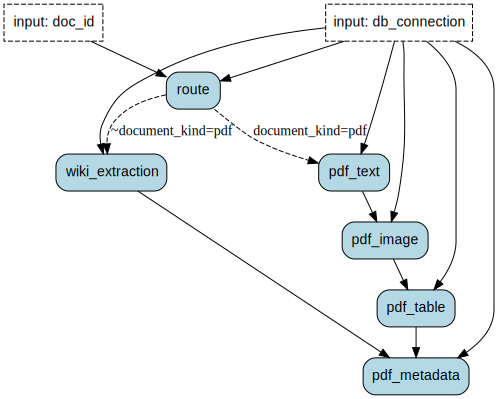

In [13]:
import pathlib
from burr.core import State, action, ApplicationBuilder
from burr.core import when

from ragnostic import utils

@action(reads=[], writes=["document_kind"])
def document_router(state: State, doc_id: str, db_connection) -> State:
    """Determine how to process the doc"""

    # Determine how to process the doc id based on the library entry
    # - Is it a PDF or a HTML?
    # - has it already been processed before?

    #Design Choices:
    # - should we load the document here or later?
    # - if loaded should we store it in the state as a python object?
    return state.update(document_kind='pdf')

@action(reads=[], writes=[])
def text_extraction(state: State, db_connection) -> State:
    """extract text"""
    # Extract text from pdf
    # - use the docling parser
    # - grab the raw text as is initially

    # Design Choices:
    # - should we store the docling parsed object in state and run various extraction steps on it?
    return state

@action(reads=[], writes=[])
def image_extraction(state: State, db_connection) -> State:
    """extract image"""

    # Extract and add images to database
    # - take docling object and put images with their metadata in the database
    
    # Design Choices:
    # - what inputs do we need? the docling objkect? the doc id and load it from database?
    
    return state

@action(reads=[], writes=[])
def table_extraction(state: State, db_connection) -> State:
    """extract table"""
    # Extract and add tables to database
    # - take docling object and put tables with their metadata in the database
    
    # Design Choices:
    # - what inputs do we need? the docling object? the doc id and load it from database?
    
    return state

@action(reads=[], writes=[])
def wikipedia_extraction(state: State, db_connection) -> State:
    """extract wikipedia"""

    # Design choices
    # Should we grab the HTML and store it then parse?
    # - should we just use the wikipedia API?
    # - should we do an image step later as well? 
    # - how would we identify images?
    return state

@action(reads=[], writes=[])
def metadata_extraction(state: State, db_connection) -> State:
    """extract table"""

    # Compile the metadata based on the previous steps
    # - does it have images, tables, etc?
    # - how many pages, etc
    # - status updates on the steps, flags, etc.
    
    return state
    
# Build and visualize graph/logic
(
    ApplicationBuilder()
    .with_actions(
        route=document_router, 
        pdf_text=text_extraction, 
        pdf_image=image_extraction, 
        pdf_table=table_extraction,
        pdf_metadata=metadata_extraction,
        wiki_extraction=wikipedia_extraction,
    )
    .with_transitions(
        ("route", "pdf_text", when(document_kind='pdf')),
        ("pdf_text", "pdf_image"),
        ("pdf_image", "pdf_table"),
        ("pdf_table", "pdf_metadata"),
        ("route", "wiki_extraction", ~when(document_kind='pdf')),
        ("wiki_extraction", "pdf_metadata"),
    )
    .with_entrypoint("route")
    .build()
)